# This file shows how I apply hierarchical clustering algorithm to build strategies. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm as cm
%matplotlib inline
import seaborn as sns; sns.set()

In [2]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

### Exploratory data analysis &  Problem setup 

I randomly choose 100 etfs. All the data was downloaded from bloomberg terminal. The time range is from the beginning of 2017 to the end of 2018.

First, I plot the price curve for four etfs. From the price graph, I could see that XWEB and IGV have high correlation because their movement trends are quite similar. The project aims to construct a portfolio based on these 100 etfs. If two etfs have a high correlation,  I could choose to add one of them to my portfolio because adding two seems redundant, which will not reduce risk nor increase return. Then, I want to see the performance of this kind of strategies. 

I use hierarchical clustering to classify the etfs on the whole data-set. Similar etfs which are also highly correlated etfs will be grouped together. They represent the same kind of risk. The distance between two etfs is defined as sqrt(2*(1-corr)). From the below graph, intuitively, there are eight groups. Hence, I divide the groups into eight groups. Then I draw the correlation matrix before clustering and after clustering. It could be seen that clustering could reduce large amount of similar etfs, thus reducing the complex of the portfolio. 

In [3]:
etfs = pd.read_csv('Data/ETF.csv', header=0)
etfs.loc[:,'Dates'] = etfs.loc[:,'Dates'].apply(lambda dates: pd.datetime.strptime(dates, '%m/%d/%y'))
etfs = etfs.set_index('Dates')
columns = [list(etfs.columns)[i].split()[0] for i in range(len(etfs.columns))]
etfs.columns = columns
etfs.head()

,ARKW,INDL,XWEB,IGV,PSJ,XITK,FDN,CWEB,PXMG,XBI,...,ADRE,SMMV,EMGF,DEF,BJK,DBAP,FEM,NFTY,USMV,AXJV
Dates,,,,,,,,,,,,,,,,,,,,,
2017-01-03,25.4240,45.4497,57.71,110.00,47.5000,58.42,80.79,20.3300,31.3123,59.59,...,32.7903,25.9700,35.86,39.060,34.0400,22.8700,20.59,30.6495,45.34,29.1200
2017-01-04,26.1696,46.2600,57.71,111.59,48.1414,59.72,81.96,20.5299,31.9520,62.34,...,33.1400,26.3300,36.38,39.300,34.4504,23.3560,20.79,31.0590,45.55,29.5200
2017-01-05,26.3500,48.1700,57.71,111.82,48.0252,60.16,82.83,22.1100,31.7438,62.47,...,33.8500,26.1400,36.76,39.220,34.8628,23.4000,20.99,31.5085,45.60,29.8500
2017-01-06,26.5660,46.4500,57.71,112.93,48.2100,60.19,83.60,22.1100,32.1400,63.35,...,33.3700,26.1000,36.47,39.460,34.7061,23.3800,20.93,31.5085,45.66,29.6400
2017-01-09,26.7204,46.2500,57.71,112.93,48.4400,60.48,83.80,22.3572,32.2400,65.36,...,33.6500,26.0404,36.68,39.236,34.7306,23.5774,20.87,31.5085,45.44,29.6446


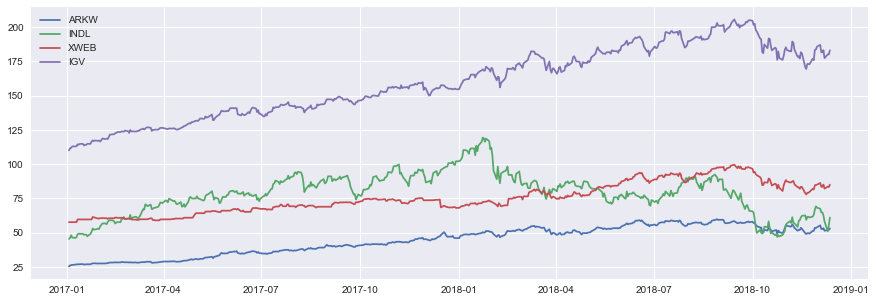

In [4]:
plt.figure(figsize=(15,5))
plt.plot(etfs.iloc[:,0],label= 'ARKW')
plt.plot(etfs.iloc[:,1],label = 'INDL')
plt.plot(etfs.iloc[:,2],label = 'XWEB')
plt.plot(etfs.iloc[:,3],label = 'IGV')
plt.legend()

Text(110.0, 0.5, 'euclidean distance')

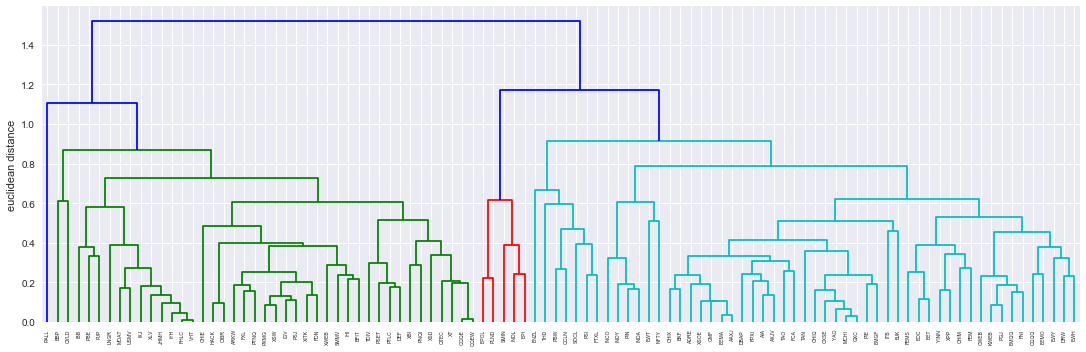

In [5]:
## calculate correlation matrix
corr = etfs.corr()
dist = np.sqrt(2*(1-corr))
condensed_dist = dist.values[np.triu_indices(len(dist))]
condensed_dist = condensed_dist[np.where(condensed_dist != 0)]
cls=linkage(condensed_dist, method='complete')
plt.figure(figsize=(15,5))
dendr=dendrogram(cls, labels=dist.columns)
plt.tight_layout()
plt.ylabel('euclidean distance')

Text(110.125, 0.5, 'euclidean distance')

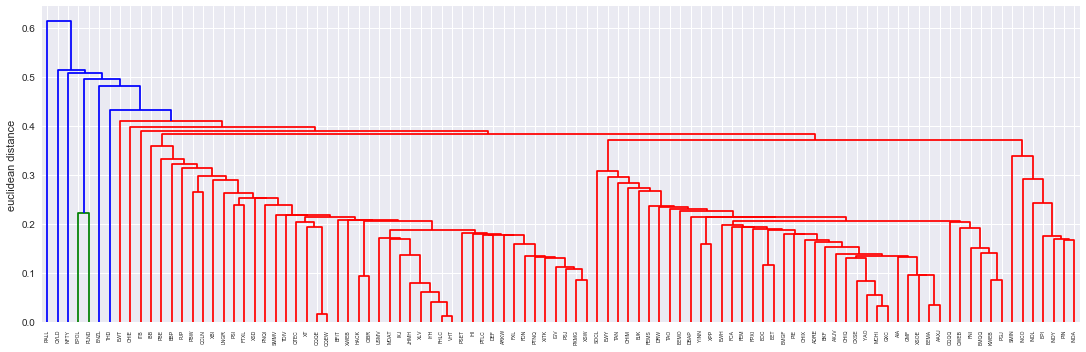

In [6]:
cls1=linkage(condensed_dist, method='single')
plt.figure(figsize=(15,5))
dendr=dendrogram(cls1, labels=dist.columns)
plt.tight_layout()
plt.ylabel('euclidean distance')

Text(110.125, 0.5, 'euclidean distance')

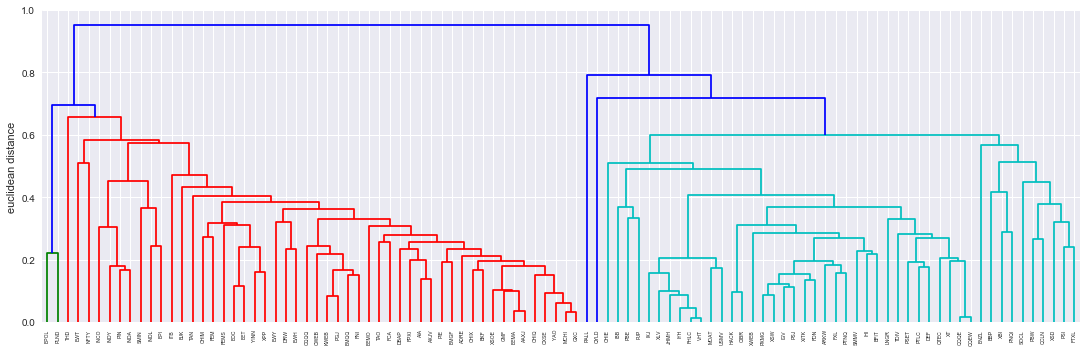

In [7]:
cls2=linkage(condensed_dist, method='average')
plt.figure(figsize=(15,5))
dendr=dendrogram(cls2, labels=dist.columns)
plt.tight_layout()
plt.ylabel('euclidean distance')

From these three graphs, I found that linkage of complete methods produces a best categoring result because it seems that assets are evenly distributed among the groups. Hence, I choose linkage of complete methods and choose eight categories for the following calculation.

In [8]:
predict = cut_tree(cls, n_clusters=8)
predict = predict.flatten()
sort = []
sort_ = []
for i in range(8):
    sort.append(list(np.where(predict == i)[0]))
    for j in range(len(sort[i])):
        sort_.append(sort[i][j])
etfs_sort = etfs.loc[:,etfs.columns[sort_]]

In [9]:
def correlation_matrix(df):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title('Correlation matrix')
    fig.colorbar(cax, ticks=[.75,.8,.85,.90,.95,1])
    plt.show()

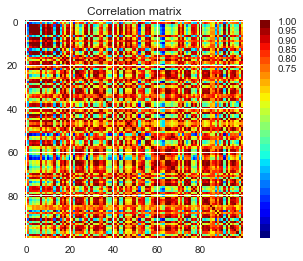

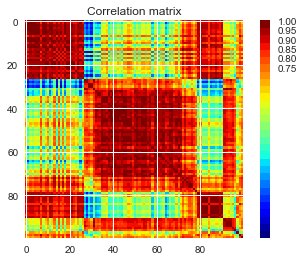

In [10]:
correlation_matrix(etfs)
correlation_matrix(etfs_sort)

### Model calibration & Evaluation

The following part is the most important part of the project. I will illustrate my strategy first. I use 200 days' time series to calculate the correlation and the distance between the efts. Then, I use hierarchical clustering to classify etfs into eight groups. In each group, I will choose one etf which has the highest return during these 200 days. All in all, I will have one portfolio that consists of eight etfs. Inverse volatility weight and equal weight will be calculated and be assigned to these eight assets. Then, I calculate the cumulative return in the following 20 days. For every 20 trading days, I will reconstruct the portfolio based on the same strategy. And I will get roughly 1 year's cumulative return of this strategy. 

In [11]:
def hierarchical_clustering(n):
    '''
    n represents the times to do the clustering
    '''
    temp = etfs.iloc[(n-1)*20:(n-1)*20+200,:]
    corr = temp.corr()
    dist = np.sqrt(2*(1-corr))
    condensed_dist = dist.values[np.triu_indices(len(dist))]
    condensed_dist = condensed_dist[np.where(condensed_dist != 0)]
    cls=linkage(condensed_dist, method='complete')
    predict = cut_tree(cls, n_clusters=8)
    predict = predict.flatten()
    return predict

In [12]:
# get eight assets
def get_portfolio(predict, n):
    portfolio = []
    for i in range(8):
        temp = etfs.iloc[(n-1)*20:(n-1)*20+200,np.where(predict == i)[0]]
        rtn = temp.pct_change(periods = 200).iloc[-1]
        portfolio.append(temp.columns[rtn.values.argmax()])
    return portfolio

In [13]:
# get weights of assets based on inverse volatility weight method
def get_IV_weight(portfolio,n):
    volatility = etfs.ix[(n-1)*20:(n-1)*20+200,portfolio].std()
    inverse_vol = 1/volatility
    weight = inverse_vol/inverse_vol.sum()
    return weight

In [14]:
# get weights of assets based on equal weight method
def get_equal_weight(portfolio):
    weight = pd.Series([1/8]*8, index = portfolio)
    return weight

In [15]:
predict_times = int((etfs.shape[0]-200)/20)
predict_times

15

In [16]:
# calculate the daily return 
def get_return (portfolio, weight, n):
    ret= np.sum(etfs.ix[199+20*(n-1):200+20*n,portfolio].pct_change()[1:]*weight, axis=1).values.reshape(20,1)
    return ret

In [17]:
ret_IV = pd.DataFrame(index = etfs.index, columns = ['daily_return'])
ret_equal = pd.DataFrame(index = etfs.index, columns = ['daily_return'])
for i in range(1, predict_times+1):
    predict = hierarchical_clustering(i)
    portfolio = get_portfolio(predict, i)
    weight_IV = get_IV_weight(portfolio,i)
    weight_equal = get_equal_weight(portfolio)
    r_IV = get_return (portfolio, weight_IV,i)
    r_equal = get_return (portfolio, weight_equal,i)
    ret_IV.iloc[(i-1)*20+200:i*20+200,:] = r_IV  
    ret_equal.iloc[(i-1)*20+200:i*20+200,:] = r_equal

/Users/lijinglan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
ret_IV = ret_IV.dropna()
ret_equal = ret_equal.dropna()

In [19]:
# calculate the cumulative return
cum_IV = ret_IV+1
cum_return_IV = cum_IV.cumprod()-1
cum_return_IV.columns = ['cumulative_return']
cum_return_IV.shape
cum_equal = ret_equal+1
cum_return_equal = cum_equal.cumprod()-1
cum_return_equal.columns = ['cumulative_return']

I choose S&P500 as a benchmark to compare the performance of the cumulative return of my portfolio against the cumulative return of  S&P500. In this part, I mainly calulate the cumulative return of S&P500 and draw the comparison graph. 

In [20]:
sp500 = pd.read_csv('Data/S&P500.csv', header=0)
sp500.loc[:,'Date'] = sp500.loc[:,'Date'].apply(lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d'))
sp500 = sp500.set_index('Date')
sp500 = sp500.loc[cum_return_equal.index[0]:,:]
sp500 = sp500.loc[:,'Adj Close']

In [21]:
ret_sp = sp500.pct_change().dropna()
cum_sp = ret_sp+1
cum_sp = cum_sp.cumprod()-1
cum_sp.columns = ['cumulative_return']

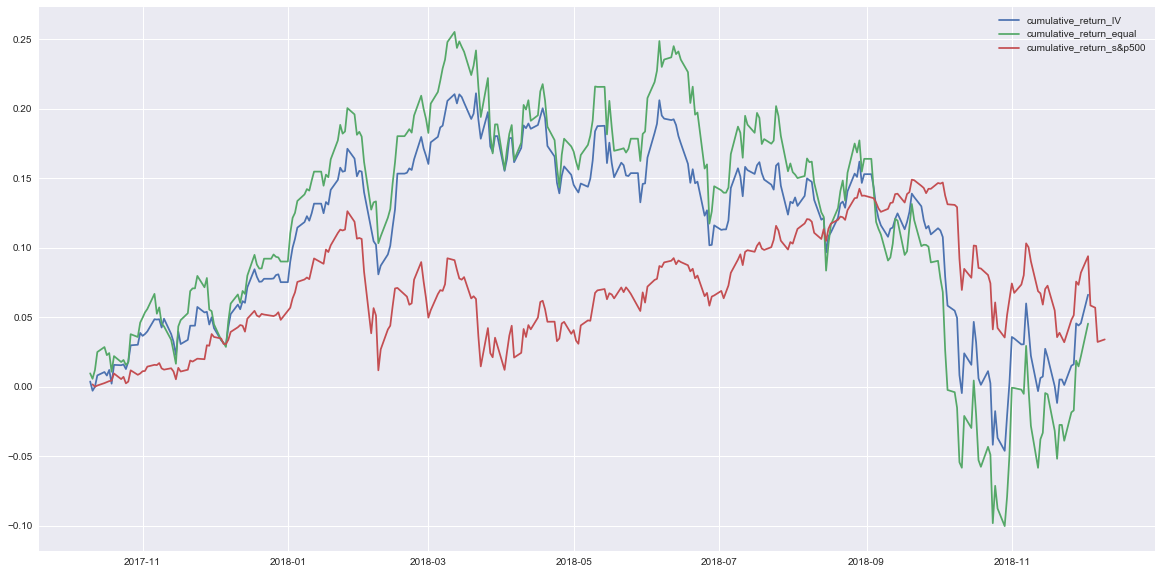

In [22]:
plt.figure(figsize=(20,10))
plt.plot(cum_return_IV,label='cumulative_return_IV')
plt.plot(cum_return_equal,label='cumulative_return_equal')
plt.plot(cum_sp, label = 'cumulative_return_s&p500')
plt.legend()

### Conclusion:
From the above graphs, we could see when market is in good condition, my strategy will beat the benchmark, while in bad condition, it will suffer more loss than the benchmark. Additionally, equal weighting method is much more fragile than the inverse volatility methods. In other words, it gains more in good market condition but lose more in bad market condition.